In [2]:
!pip install ssqueezepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 6.0 MB/s eta 0:00:00


In [3]:
import os
import librosa
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from ssqueezepy import ssq_cwt

In [4]:
import os
import tqdm
import numpy as np
import librosa
from ssqueezepy import ssq_cwt

# Define paths and labels
base_dir = "/content/drive/MyDrive/signal_analysis/data"
class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']

# Function to process dataset and return SST features
def process_dataset_with_sst(base_dir, class_labels, sampling_rate=2000, fixed_length=300):
    X_sst = []
    y_labels = []

    for label in class_labels:
        folder_path = os.path.join(base_dir, label)

        for file_name in tqdm.tqdm(os.listdir(folder_path)):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)

                # Load and preprocess audio
                signal, sr = librosa.load(file_path, sr=None)
                signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
                signal = signal / np.max(np.abs(signal))

                # Apply SST using Continuous Wavelet Transform
                Tx, Wx, ssq_freqs, *_ = ssq_cwt(signal, fs=sampling_rate)

                # Take the magnitude or mean energy as a feature
                sst_feature = np.mean(np.abs(Tx), axis=1)  # shape: (freq_bins,)

                # Pad or trim to fixed length
                if len(sst_feature) < fixed_length:
                    sst_feature = np.pad(sst_feature, (0, fixed_length - len(sst_feature)), mode='constant')
                else:
                    sst_feature = sst_feature[:fixed_length]

                X_sst.append(sst_feature)
                y_labels.append(label)

    return np.array(X_sst), np.array(y_labels)

# Process the dataset with SST
X_sst, y_sst = process_dataset_with_sst(base_dir, class_labels)


100%|██████████| 200/200 [01:05<00:00,  3.05it/s]


# **Process Dataset with SST**

In [5]:
def process_dataset_with_sst(base_dir, class_labels, sampling_rate=2000, feature_length=300):
    X_sst = []
    y_labels = []

    def pad_or_truncate(feature, target_length):
        if len(feature) > target_length:
            return feature[:target_length]
        else:
            return np.pad(feature, (0, target_length - len(feature)), mode='constant')

    for label in class_labels:
        folder_path = os.path.join(base_dir, label)

        for file_name in tqdm.tqdm(os.listdir(folder_path)):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)

                # Load and preprocess audio
                signal, sr = librosa.load(file_path, sr=None)
                signal = librosa.resample(signal, orig_sr=sr, target_sr=sampling_rate)
                signal = signal / np.max(np.abs(signal))

                # Apply SST using Continuous Wavelet Transform
                Tx, Wx, ssq_freqs, *_ = ssq_cwt(signal, fs=sampling_rate)

                # Compute SST feature
                sst_feature = np.mean(np.abs(Tx), axis=1)
                sst_feature = pad_or_truncate(sst_feature, feature_length)

                X_sst.append(sst_feature)
                y_labels.append(label)

    return np.array(X_sst), np.array(y_labels)


In [6]:
X_sst, y_sst = process_dataset_with_sst(base_dir, class_labels)


100%|██████████| 200/200 [01:00<00:00,  3.31it/s]


In [7]:
type(y_sst)

numpy.ndarray

In [8]:
np.unique(y_sst)

array(['AS', 'MR', 'MS', 'MVP', 'N'], dtype='<U3')

In [9]:
# Get unique elements and create a mapping to integers
unique_elements = np.unique(y_sst)
mapping = {elem: idx for idx, elem in enumerate(unique_elements)}

# Map the original array to integers
y_enc = np.vectorize(mapping.get)(y_sst)

In [10]:
import pandas as pd

# Assuming y_train is a NumPy array or a pandas Series
y_onehot = pd.get_dummies(y_enc).values
y_onehot.shape

(1000, 5)

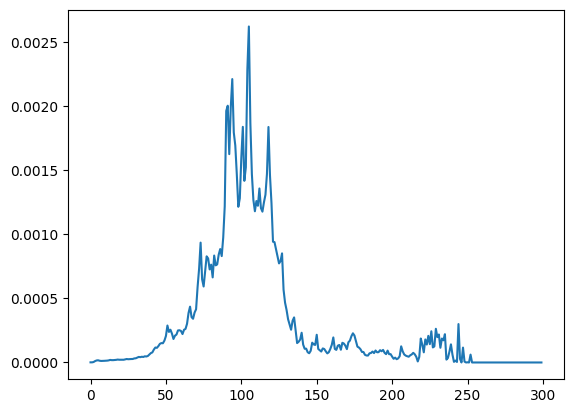

In [11]:
plt.plot(X_sst[0])

In [12]:
from ssqueezepy import ssq_cwt

max_time_frames = 0
X_sst_mag = []

# Step 1: Compute SST and track max time frames
for signal in tqdm.tqdm(X_sst):
    Tx, _, _, _ = ssq_cwt(signal, fs=2000)  # Apply SST
    Tx_mag = np.abs(Tx)  # Take magnitude of SST

    X_sst_mag.append(Tx_mag)
    max_time_frames = max(max_time_frames, Tx_mag.shape[1])  # Time dimension

# Step 2: Pad SST results along time axis
padded_X_sst = []

for Tx_mag in X_sst_mag:
    padded_result = np.pad(Tx_mag, ((0, 0), (0, max_time_frames - Tx_mag.shape[1])), mode='constant')
    padded_X_sst.append(padded_result)

# Step 3: Convert list to numpy array
X_sst = np.array(padded_X_sst)


100%|██████████| 1000/1000 [00:49<00:00, 20.04it/s]


In [13]:
X_sst.shape

(1000, 221, 300)

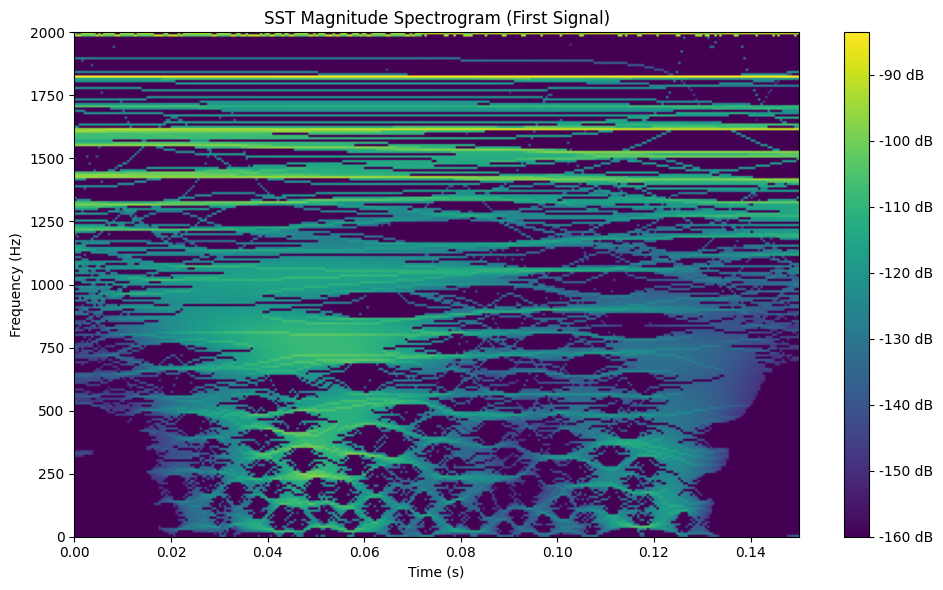

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the SST magnitude spectrogram for the first signal
plt.figure(figsize=(10, 6))
plt.imshow(20 * np.log10(X_sst[0] + 1e-8),  # dB scale with small constant to avoid log(0)
           aspect='auto',
           origin='lower',
           cmap='viridis',
           extent=[0, X_sst[0].shape[1] / 2000, 0, 2000])  # time in seconds, freq up to 2kHz

plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("SST Magnitude Spectrogram (First Signal)")
plt.tight_layout()
plt.show()


# **CNN Model**

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# === 1. Split the dataset ===
X_train, X_test, y_train, y_test = train_test_split(
    X_sst, y_onehot, test_size=0.2, random_state=42
)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (800, 221, 300)
X_test shape: (200, 221, 300)
y_train shape: (800, 5)
y_test shape: (200, 5)


In [16]:
# === 2. Reshape SST input for Conv1D ===
# Convert shape from (samples, freq_bins, time_frames) → (samples, time_frames, freq_bins)
X_train_cnn = X_train.transpose(0, 2, 1)
X_test_cnn = X_test.transpose(0, 2, 1)

print(f'X_train_cnn shape: {X_train_cnn.shape}')  # Example: (samples, 64, 128)
print(f'X_test_cnn shape: {X_test_cnn.shape}')

X_train_cnn shape: (800, 300, 221)
X_test_cnn shape: (200, 300, 221)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Define the 3-layer CNN model
model = Sequential([
    # 1st CNN Block
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # 2nd CNN Block
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # 3rd CNN Block
    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # Global average pooling and fully connected layers
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 296, 64)        │        70,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 148, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 146, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 73, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 71, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 35, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 35, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,381 (896.02 KB)

 Trainable params: 228,485 (892.52 KB)

 Non-trainable params: 896 (3.50 KB)

In [21]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\n CNN Test Accuracy: {test_acc * 100:.2f}%")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.9664 - loss: 0.1065 - val_accuracy: 0.1650 - val_loss: 115.1967
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.9699 - loss: 0.0847 - val_accuracy: 0.1850 - val_loss: 157.2247
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9949 - loss: 0.0588 - val_accuracy: 0.1850 - val_loss: 366.9859
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9774 - loss: 0.0734 - val_accuracy: 0.1850 - val_loss: 421.1558
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - accuracy: 0.9826 - loss: 0.0582 - val_accuracy: 0.1850 - val_loss: 361.9653
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.9767 - loss: 0.0667 - val_accuracy: 0.1850 - val_loss: 781.7576
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.9908 - loss: 0.0341 - val_accuracy: 0.1850 - val_loss: 799.5028
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.9847 - loss: 0.0442 - v

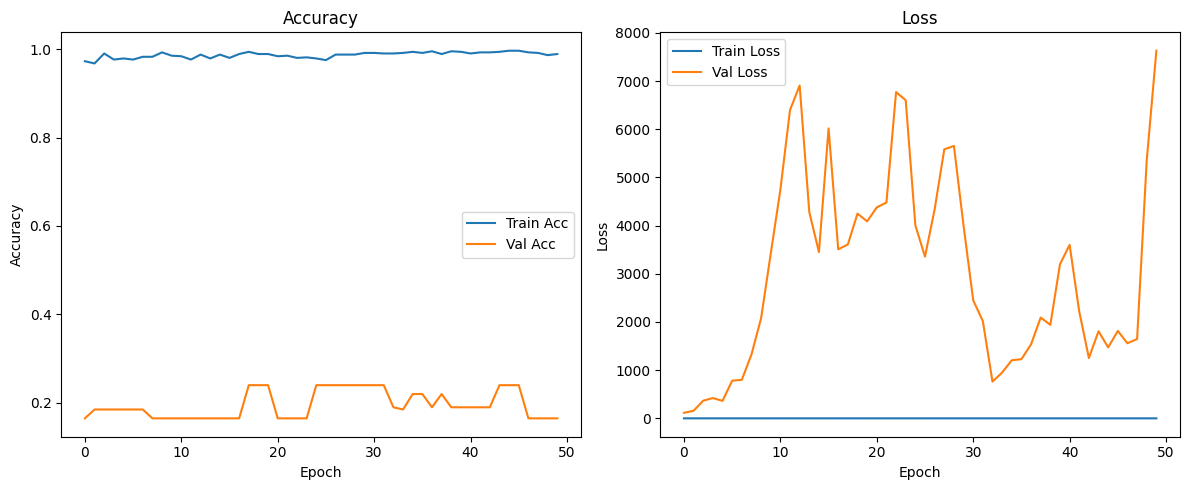

In [22]:
# === 6. Plot Accuracy and Loss ===
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.1650
Test Loss: 7631.1274


# **GRU -> Flatten -> Dense Layer**

In [25]:
# # PREVIOUS CODE USED FLATTEN



# from sklearn.model_selection import train_test_split
# import numpy as np

# # X_sst is (samples, freq_bins, time_frames)
# # y_onehot is (samples, num_classes)

# # Split SST features and labels into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sst, y_onehot, test_size=0.2, random_state=42)

# # Display shapes
# print(f'X_train shape: {X_train.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'y_train shape: {y_train.shape}')
# print(f'y_test shape: {y_test.shape}')

In [26]:
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Flatten, Dense, Dropout, BatchNormalization

# === 1. Split the data ===
X_train, X_test, y_train, y_test = train_test_split(X_sst, y_onehot, test_size=0.2, random_state=42)

# === 2. Normalize ===
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [ ]:
# # PREVIOUS CODE USED FLATTEN





# import tensorflow as tf
# from tensorflow.keras import layers, models

# # Assuming:
# # X_train and X_test are SST features (samples, freq_bins, time_frames)

# # Add channel dimension for CNN: (samples, height, width, channels)
# X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# print(f'X_train_cnn shape: {X_train_cnn.shape}')
# print(f'X_test_cnn shape: {X_test_cnn.shape}')


In [27]:
# === 3. Reshape: (samples, time_steps, features)
X_train_cnn = X_train.transpose(0, 2, 1)
X_test_cnn = X_test.transpose(0, 2, 1)

print(f'X_train_cnn shape: {X_train_cnn.shape}')  # (samples, time, features)
print(f'X_test_cnn shape: {X_test_cnn.shape}')


X_train_cnn shape: (800, 300, 221)
X_test_cnn shape: (200, 300, 221)


In [28]:
X_train_cnn.shape

(800, 300, 221)

In [32]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# # Define the CNN model
# cnn_model = Sequential([
#     Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
#     MaxPooling1D(pool_size=2),
#     BatchNormalization(),

#     Conv1D(64, kernel_size=5, activation='relu'),
#     MaxPooling1D(pool_size=2),
#     BatchNormalization(),

#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(y_train.shape[1], activation='softmax')  # Softmax for multi-class classification
# ])


In [33]:
# === 4. Define CNN + GRU + Flatten model ===
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    GRU(64, return_sequences=True),   # <-- key: keep sequence output
    Flatten(),                        # <-- flatten full GRU output

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 296, 32)        │        35,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 148, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 148, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 144, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 72, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 72, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 72, 64)         │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 661,637 (2.52 MB)

 Trainable params: 661,445 (2.52 MB)

 Non-trainable params: 192 (768.00 B)

In [35]:
# # PREVIOUS USED CODE


# # --- Compile the CNN + GRU model ---
# cnn_gru_model.compile(optimizer='adam',
#                       loss='categorical_crossentropy',
#                       metrics=['accuracy'])

# # --- Train the CNN + GRU model ---
# history = cnn_gru_model.fit(
#     X_train_cnn, y_train,
#     epochs=30,
#     batch_size=32,
#     validation_data=(X_test_cnn, y_test),
#     verbose=1
# )

# # --- Evaluate CNN + GRU on test data ---
# cnn_accuracy = cnn_gru_model.evaluate(X_test_cnn, y_test, verbose=0)
# print(f"CNN + GRU Accuracy: {cnn_accuracy[1] * 100:.2f}%")


In [37]:
# Compile the model
model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Train the model
history = model.fit(X_train_cnn, y_train,
                            epochs=30,
                            batch_size=32,
                            validation_data=(X_test_cnn, y_test),
                            verbose=1)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.6373 - loss: 1.1094 - val_accuracy: 0.4100 - val_loss: 1.5258
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.8921 - loss: 0.3294 - val_accuracy: 0.2650 - val_loss: 1.4358
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9624 - loss: 0.1309 - val_accuracy: 0.2150 - val_loss: 1.4921
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9698 - loss: 0.0844 - val_accuracy: 0.1900 - val_loss: 1.5431
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.9869 - loss: 0.0499 - val_accuracy: 0.1900 - val_loss: 1.4714
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.9846 - loss: 0.0473 - val_accuracy: 0.1900 - val_loss: 1.3833
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9779 - loss: 0.0868 - val_accuracy: 0.1900 - val_loss: 1.7049
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.9828 - loss: 0.0428 - val_accuracy: 0.

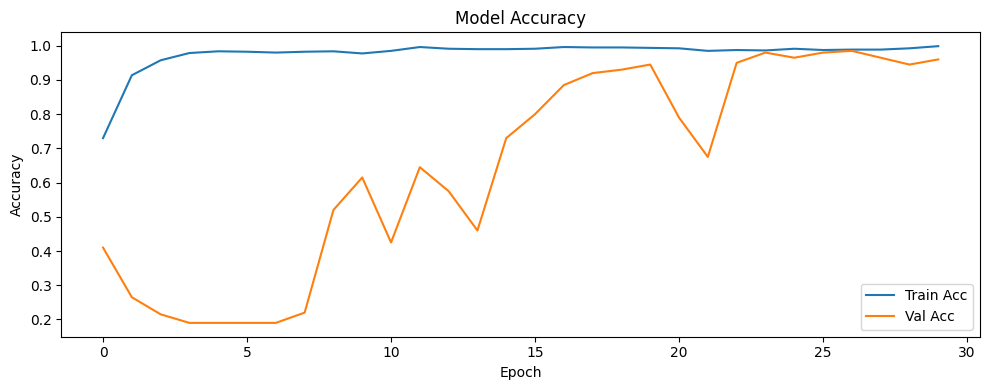

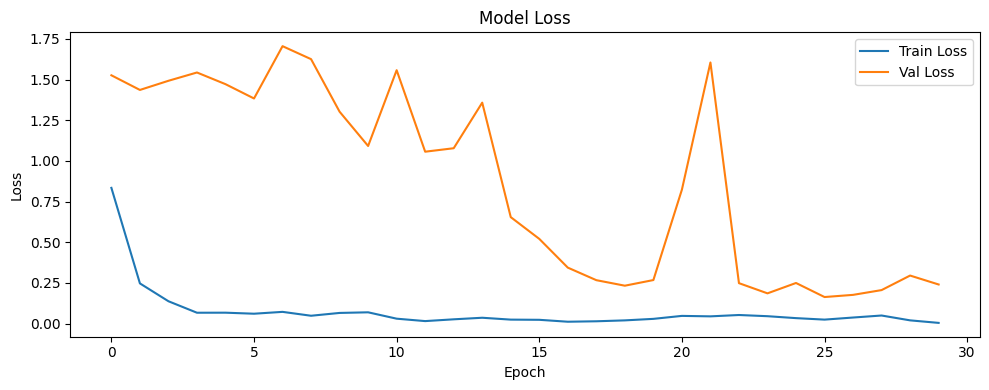

In [38]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9600
Test Loss: 0.2399


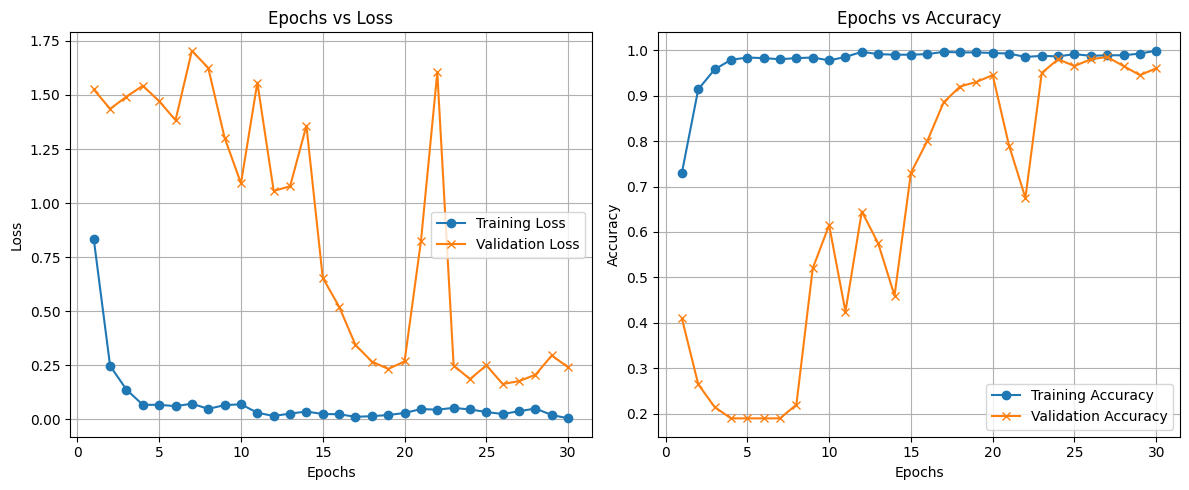

In [41]:
import matplotlib.pyplot as plt

# Extract training history
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Final layout
plt.tight_layout()
plt.show()


# **CNN + Attention Model**

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models

class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.query = self.add_weight(name="query", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform")
        self.key   = self.add_weight(name="key", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform")
        self.value = self.add_weight(name="value", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform")

    def call(self, inputs):
        Q = tf.matmul(inputs, self.query)
        K = tf.matmul(inputs, self.key)
        V = tf.matmul(inputs, self.value)

        attention_scores = tf.matmul(Q, K, transpose_b=True)
        attention_weights = tf.nn.softmax(attention_scores / tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32)), axis=-1)

        return tf.matmul(attention_weights, V)


# Define the CNN-Attention Model
inputs = layers.Input(shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1))

x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Reshape for Attention Layer (convert to sequences: batch, time, features)
x = layers.Reshape((-1, x.shape[-1]))(x)  # shape: (batch_size, time_steps, features)

x = AttentionLayer()(x)  # Apply custom attention

x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(5, activation='softmax')(x)

cnn_attention_model = models.Model(inputs=inputs, outputs=outputs)


In [43]:
cnn_attention_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 300, 221, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 298, 219, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 109, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 107, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3869, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 3869, 64)       │        12,288 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 247616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    15,847,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,878,917 (60.57 MB)

 Trainable params: 15,878,917 (60.57 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
# --- Compile the CNN + Attention model ---
cnn_attention_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Train the model ---
history = cnn_attention_model.fit(
    X_train_cnn, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    verbose=1
)

# --- Evaluate the model on test data ---
test_loss, test_acc = cnn_attention_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"CNN with Attention - Test Accuracy: {test_acc * 100:.2f}%")
print(f"CNN with Attention - Test Loss: {test_loss:.4f}")


NameError: name 'cnn_attention_model' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Extract training history
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create subplots
plt.figure(figsize=(12, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='x')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.grid(True)

# Final layout adjustment
plt.tight_layout()
plt.show()


# **Flatten -> GRU -> Dense layer**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, Reshape, GRU, Dense, Dropout

# === 1. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_sst, y_onehot, test_size=0.2, random_state=42
)

# === 2. Normalize the data ===
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

In [ ]:
# === 3. Reshape for Conv1D ===
X_train_cnn = X_train.transpose(0, 2, 1)  # (samples, time_frames, freq_bins)
X_test_cnn = X_test.transpose(0, 2, 1)

print(f'X_train_cnn shape: {X_train_cnn.shape}')  # Example: (samples, 64, 128)
print(f'y_train shape: {y_train.shape}')

In [ ]:
# === 4. TEMP MODEL: Check Flattened Size ===
temp_model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Flatten()
])

temp_output = temp_model.predict(X_train_cnn[:1])
flattened_size = temp_output.shape[1]
print("Flattened size:", flattened_size)  # Example: 4608

# === 5. Choose reshape dims ===
# Example: 4608 = 72 x 64 (time_steps, features)
reshape_time_steps = 72
reshape_features = 64

In [ ]:
# === 6. Final Model: CNN → Flatten → Reshape → GRU ===
model = Sequential([
    # --- CNN layers ---
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Conv1D(64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    Flatten(),

    Reshape((reshape_time_steps, reshape_features)),  # Must match total units: reshape_time_steps * reshape_features = flattened_size

    GRU(64),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')
])

In [ ]:
# === 7. Compile and train ===
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_cnn, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test_cnn, y_test),
                    verbose=1)
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


# Loss plot
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
